# Notebook 1: Neural ODE 2D Classification

Este notebook implementa e treina Neural ODEs para classificação em dados 2D.

## Objetivos:
1. Implementar VectorField e NeuralODE com classificação
2. Treinar em dataset 2D sintético (moons, circles, spirals)
3. Visualizar trajetórias a partir de dados do dataset (x(0) → x(1))
4. Visualizar transformações a partir de z ~ N(0,I) (z(0) → x(1))
5. Visualizar vector fields
6. Analisar NFEs e comparar solvers


In [2]:
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('..')
import torch
import torch.optim as optim
from src.models.neural_ode import NeuralODE
from src.models.vector_field import VectorField
from src.utils.datasets import Synthetic2D, get_dataloader
from src.utils.training import train_neural_ode, count_nfe
from src.utils.visualization import Synthetic2DViz

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Directories for saving figures and checkpoints
FIGURES_DIR = '../results/figures'
CHECKPOINTS_DIR = '../results/checkpoints'
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

# Dataset and model names for file naming
DATASET_NAME = 'moons'
MODEL_NAME = 'neuralode'

Using device: cuda


## 1. Carregar Dataset


Figure saved to: ../results/figures/01_moons_neuralode.png


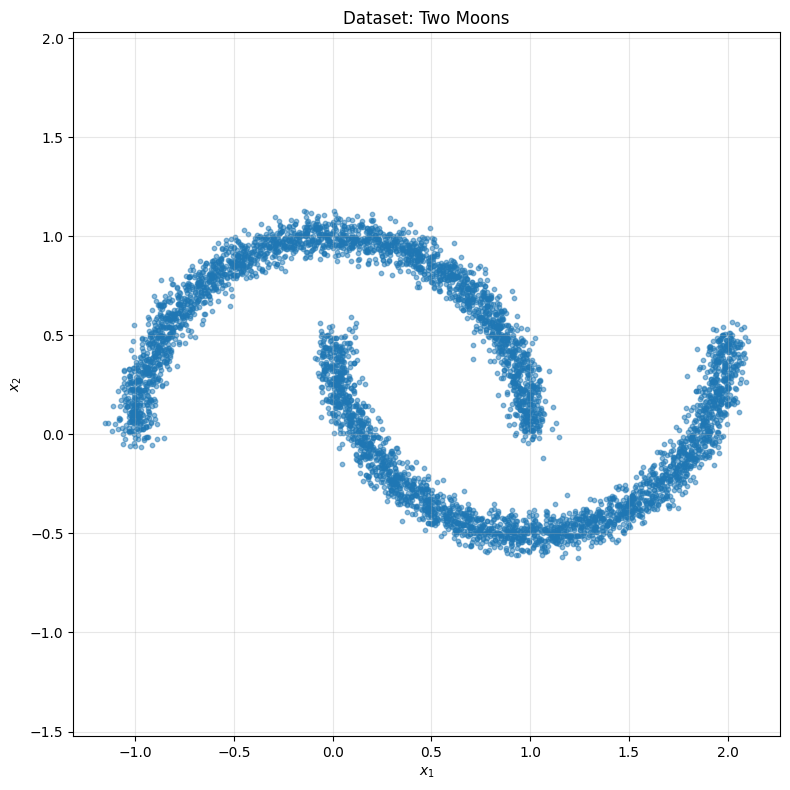

Dataset size: 5000


In [3]:
# Criar dataset (moons, circles, ou spirals - todos têm 2 classes)
dataset = Synthetic2D(n_samples=5000, noise=0.05, dataset_type=DATASET_NAME)
dataloader = get_dataloader(dataset, batch_size=128, shuffle=True)

# Visualizar dados com cores por classe
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
Synthetic2DViz.plot_data_distribution(
    dataset.data,
    ax=ax,
    title="Dataset: Two Moons",
    save_path=os.path.join(FIGURES_DIR, f'01_{DATASET_NAME}_{MODEL_NAME}.png')
)
plt.tight_layout()
plt.show()
print(f"Dataset size: {len(dataset)}")

## 2. Criar e Treinar Modelo


In [ ]:
# Criar modelo com classificação (2 classes para moons/circles/spirals)
vf = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
model = NeuralODE(
    vf,
    solver='euler',
    rtol=1e-5,
    atol=1e-5,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Treinar para classificação
train_neural_ode(
    model,
    dataloader,
    optimizer,
    n_epochs=100,
)

# Salvar checkpoint
checkpoint_path = os.path.join(
    CHECKPOINTS_DIR,
    f'01__{DATASET_NAME}_{MODEL_NAME}.pt'
)
torch.save(model.state_dict(), checkpoint_path)
print(f"Checkpoint saved to: {checkpoint_path}")


Epoch 1/100:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 40/40 [00:03<00:00, 12.31it/s]


Epoch 1, Loss: 0.079207


Epoch 2/100: 100%|██████████| 40/40 [00:03<00:00, 12.66it/s]


Epoch 2, Loss: 0.069838


Epoch 3/100: 100%|██████████| 40/40 [00:06<00:00,  5.81it/s]


Epoch 3, Loss: 0.050702


Epoch 4/100: 100%|██████████| 40/40 [00:07<00:00,  5.01it/s]


Epoch 4, Loss: 0.047866


Epoch 5/100: 100%|██████████| 40/40 [00:08<00:00,  4.48it/s]


Epoch 5, Loss: 0.043310


Epoch 6/100: 100%|██████████| 40/40 [00:08<00:00,  4.52it/s]


Epoch 6, Loss: 0.035614


Epoch 7/100: 100%|██████████| 40/40 [00:06<00:00,  5.83it/s]


Epoch 7, Loss: 0.032731


Epoch 8/100: 100%|██████████| 40/40 [00:06<00:00,  5.82it/s]


Epoch 8, Loss: 0.028339


Epoch 9/100: 100%|██████████| 40/40 [00:06<00:00,  6.62it/s]


Epoch 9, Loss: 0.022475


Epoch 10/100: 100%|██████████| 40/40 [00:04<00:00,  8.34it/s]


Epoch 10, Loss: 0.021123


Epoch 11/100: 100%|██████████| 40/40 [00:04<00:00,  9.09it/s]


Epoch 11, Loss: 0.014001


Epoch 12/100: 100%|██████████| 40/40 [00:02<00:00, 13.77it/s]


Epoch 12, Loss: 0.005309


Epoch 13/100: 100%|██████████| 40/40 [00:02<00:00, 14.27it/s]


Epoch 13, Loss: 0.005496


Epoch 14/100: 100%|██████████| 40/40 [00:02<00:00, 14.48it/s]


Epoch 14, Loss: 0.005017


Epoch 15/100: 100%|██████████| 40/40 [00:02<00:00, 14.95it/s]


Epoch 15, Loss: 0.003977


Epoch 16/100: 100%|██████████| 40/40 [00:02<00:00, 14.23it/s]


Epoch 16, Loss: 0.010071


Epoch 17/100: 100%|██████████| 40/40 [00:02<00:00, 15.40it/s]


Epoch 17, Loss: 0.006240


Epoch 18/100: 100%|██████████| 40/40 [00:02<00:00, 14.65it/s]


Epoch 18, Loss: 0.006698


Epoch 19/100: 100%|██████████| 40/40 [00:02<00:00, 15.20it/s]


Epoch 19, Loss: 0.010414


Epoch 20/100: 100%|██████████| 40/40 [00:02<00:00, 14.99it/s]


Epoch 20, Loss: 0.004479


Epoch 21/100: 100%|██████████| 40/40 [00:02<00:00, 15.42it/s]


Epoch 21, Loss: 0.005583


Epoch 22/100: 100%|██████████| 40/40 [00:02<00:00, 15.79it/s]


Epoch 22, Loss: 0.010885


Epoch 23/100: 100%|██████████| 40/40 [00:02<00:00, 15.21it/s]


Epoch 23, Loss: 0.006719


Epoch 24/100: 100%|██████████| 40/40 [00:02<00:00, 14.55it/s]


Epoch 24, Loss: 0.008734


Epoch 25/100: 100%|██████████| 40/40 [00:02<00:00, 15.44it/s]


Epoch 25, Loss: 0.009555


Epoch 26/100: 100%|██████████| 40/40 [00:02<00:00, 14.97it/s]


Epoch 26, Loss: 0.007962


Epoch 27/100: 100%|██████████| 40/40 [00:02<00:00, 14.49it/s]


Epoch 27, Loss: 0.008185


Epoch 28/100: 100%|██████████| 40/40 [00:02<00:00, 13.76it/s]


Epoch 28, Loss: 0.008692


Epoch 29/100: 100%|██████████| 40/40 [00:02<00:00, 14.09it/s]


Epoch 29, Loss: 0.007257


Epoch 30/100: 100%|██████████| 40/40 [00:02<00:00, 15.28it/s]


Epoch 30, Loss: 0.004661


Epoch 31/100: 100%|██████████| 40/40 [00:02<00:00, 13.35it/s]


Epoch 31, Loss: 0.004573


Epoch 32/100: 100%|██████████| 40/40 [00:02<00:00, 14.07it/s]


Epoch 32, Loss: 0.003715


Epoch 33/100: 100%|██████████| 40/40 [00:02<00:00, 13.67it/s]


Epoch 33, Loss: 0.012961


Epoch 34/100: 100%|██████████| 40/40 [00:02<00:00, 15.06it/s]


Epoch 34, Loss: 0.009951


Epoch 35/100: 100%|██████████| 40/40 [00:02<00:00, 14.55it/s]


Epoch 35, Loss: 0.006386


Epoch 36/100: 100%|██████████| 40/40 [00:02<00:00, 15.59it/s]


Epoch 36, Loss: 0.003309


Epoch 37/100: 100%|██████████| 40/40 [00:02<00:00, 14.81it/s]


Epoch 37, Loss: 0.005192


Epoch 38/100: 100%|██████████| 40/40 [00:02<00:00, 15.25it/s]


Epoch 38, Loss: 0.008802


Epoch 39/100: 100%|██████████| 40/40 [00:02<00:00, 15.11it/s]


Epoch 39, Loss: 0.003435


Epoch 40/100: 100%|██████████| 40/40 [00:02<00:00, 14.60it/s]


Epoch 40, Loss: 0.007490


Epoch 41/100: 100%|██████████| 40/40 [00:02<00:00, 15.30it/s]


Epoch 41, Loss: 0.003328


Epoch 42/100: 100%|██████████| 40/40 [00:02<00:00, 14.68it/s]


Epoch 42, Loss: 0.006657


Epoch 43/100: 100%|██████████| 40/40 [00:02<00:00, 15.03it/s]


Epoch 43, Loss: 0.011449


Epoch 44/100: 100%|██████████| 40/40 [00:02<00:00, 14.37it/s]


Epoch 44, Loss: 0.003268


Epoch 45/100: 100%|██████████| 40/40 [00:02<00:00, 14.93it/s]


Epoch 45, Loss: 0.009782


Epoch 46/100: 100%|██████████| 40/40 [00:02<00:00, 14.24it/s]


Epoch 46, Loss: 0.006952


Epoch 47/100: 100%|██████████| 40/40 [00:02<00:00, 15.05it/s]


Epoch 47, Loss: 0.004168


Epoch 48/100: 100%|██████████| 40/40 [00:02<00:00, 14.97it/s]


Epoch 48, Loss: 0.003743


Epoch 49/100: 100%|██████████| 40/40 [00:02<00:00, 14.60it/s]


Epoch 49, Loss: 0.003597


Epoch 50/100: 100%|██████████| 40/40 [00:02<00:00, 14.49it/s]


Epoch 50, Loss: 0.005994


Epoch 51/100: 100%|██████████| 40/40 [00:02<00:00, 14.22it/s]


Epoch 51, Loss: 0.003959


Epoch 52/100: 100%|██████████| 40/40 [00:02<00:00, 14.25it/s]


Epoch 52, Loss: 0.008975


Epoch 53/100: 100%|██████████| 40/40 [00:02<00:00, 14.44it/s]


Epoch 53, Loss: 0.003116


Epoch 54/100: 100%|██████████| 40/40 [00:02<00:00, 14.80it/s]


Epoch 54, Loss: 0.007146


Epoch 55/100: 100%|██████████| 40/40 [00:02<00:00, 14.70it/s]


Epoch 55, Loss: 0.008221


Epoch 56/100: 100%|██████████| 40/40 [00:02<00:00, 14.36it/s]


Epoch 56, Loss: 0.008547


Epoch 57/100: 100%|██████████| 40/40 [00:02<00:00, 15.35it/s]


Epoch 57, Loss: 0.007422


Epoch 58/100: 100%|██████████| 40/40 [00:02<00:00, 15.57it/s]


Epoch 58, Loss: 0.003177


Epoch 59/100: 100%|██████████| 40/40 [00:02<00:00, 14.85it/s]


Epoch 59, Loss: 0.003444


Epoch 60/100: 100%|██████████| 40/40 [00:02<00:00, 15.36it/s]


Epoch 60, Loss: 0.002441


Epoch 61/100: 100%|██████████| 40/40 [00:02<00:00, 14.73it/s]


Epoch 61, Loss: 0.005222


Epoch 62/100: 100%|██████████| 40/40 [00:02<00:00, 15.72it/s]


Epoch 62, Loss: 0.003948


Epoch 63/100: 100%|██████████| 40/40 [00:02<00:00, 15.09it/s]


Epoch 63, Loss: 0.004102


Epoch 64/100: 100%|██████████| 40/40 [00:02<00:00, 14.98it/s]


Epoch 64, Loss: 0.005411


Epoch 65/100: 100%|██████████| 40/40 [00:02<00:00, 15.15it/s]


Epoch 65, Loss: 0.005727


Epoch 66/100: 100%|██████████| 40/40 [00:02<00:00, 14.76it/s]


Epoch 66, Loss: 0.006870


Epoch 67/100: 100%|██████████| 40/40 [00:02<00:00, 14.56it/s]


Epoch 67, Loss: 0.003487


Epoch 68/100: 100%|██████████| 40/40 [00:02<00:00, 14.96it/s]


Epoch 68, Loss: 0.003101


Epoch 69/100: 100%|██████████| 40/40 [00:02<00:00, 14.85it/s]


Epoch 69, Loss: 0.006596


Epoch 70/100: 100%|██████████| 40/40 [00:02<00:00, 14.98it/s]


Epoch 70, Loss: 0.009330


Epoch 71/100: 100%|██████████| 40/40 [00:03<00:00, 13.25it/s]


Epoch 71, Loss: 0.013648


Epoch 72/100: 100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Epoch 72, Loss: 0.003624


Epoch 73/100: 100%|██████████| 40/40 [00:02<00:00, 14.34it/s]


Epoch 73, Loss: 0.002893


Epoch 74/100: 100%|██████████| 40/40 [00:02<00:00, 14.03it/s]


Epoch 74, Loss: 0.004570


Epoch 75/100: 100%|██████████| 40/40 [00:02<00:00, 15.20it/s]


Epoch 75, Loss: 0.005681


Epoch 76/100: 100%|██████████| 40/40 [00:02<00:00, 14.17it/s]


Epoch 76, Loss: 0.003022


Epoch 77/100: 100%|██████████| 40/40 [00:03<00:00, 11.54it/s]


Epoch 77, Loss: 0.003880


Epoch 78/100: 100%|██████████| 40/40 [00:02<00:00, 13.56it/s]


Epoch 78, Loss: 0.006920


Epoch 79/100: 100%|██████████| 40/40 [00:02<00:00, 15.19it/s]


Epoch 79, Loss: 0.007019


Epoch 80/100: 100%|██████████| 40/40 [00:02<00:00, 15.12it/s]


Epoch 80, Loss: 0.007460


Epoch 81/100: 100%|██████████| 40/40 [00:02<00:00, 15.12it/s]


Epoch 81, Loss: 0.008743


Epoch 82/100: 100%|██████████| 40/40 [00:02<00:00, 14.92it/s]


Epoch 82, Loss: 0.006633


Epoch 83/100: 100%|██████████| 40/40 [00:02<00:00, 14.80it/s]


Epoch 83, Loss: 0.004497


Epoch 84/100: 100%|██████████| 40/40 [00:02<00:00, 15.70it/s]


Epoch 84, Loss: 0.002258


Epoch 85/100: 100%|██████████| 40/40 [00:02<00:00, 14.65it/s]


Epoch 85, Loss: 0.004717


Epoch 86/100: 100%|██████████| 40/40 [00:02<00:00, 15.52it/s]


Epoch 86, Loss: 0.004596


Epoch 87/100: 100%|██████████| 40/40 [00:02<00:00, 14.72it/s]


Epoch 87, Loss: 0.004354


Epoch 88/100: 100%|██████████| 40/40 [00:02<00:00, 14.39it/s]


Epoch 88, Loss: 0.003894


Epoch 89/100: 100%|██████████| 40/40 [00:02<00:00, 14.75it/s]


Epoch 89, Loss: 0.006153


Epoch 90/100: 100%|██████████| 40/40 [00:02<00:00, 15.25it/s]


Epoch 90, Loss: 0.007368


Epoch 91/100: 100%|██████████| 40/40 [00:02<00:00, 14.37it/s]


Epoch 91, Loss: 0.004888


Epoch 92/100: 100%|██████████| 40/40 [00:02<00:00, 14.74it/s]


Epoch 92, Loss: 0.008476


Epoch 93/100: 100%|██████████| 40/40 [00:02<00:00, 14.38it/s]


Epoch 93, Loss: 0.004038


Epoch 94/100: 100%|██████████| 40/40 [00:02<00:00, 14.70it/s]


Epoch 94, Loss: 0.006376


Epoch 95/100: 100%|██████████| 40/40 [00:02<00:00, 14.18it/s]


Epoch 95, Loss: 0.006865


Epoch 96/100: 100%|██████████| 40/40 [00:02<00:00, 15.26it/s]


Epoch 96, Loss: 0.005798


Epoch 97/100: 100%|██████████| 40/40 [00:02<00:00, 15.11it/s]


Epoch 97, Loss: 0.003636


Epoch 98/100: 100%|██████████| 40/40 [00:02<00:00, 15.01it/s]


Epoch 98, Loss: 0.003217


Epoch 99/100: 100%|██████████| 40/40 [00:02<00:00, 13.89it/s]


Epoch 99, Loss: 0.009285


Epoch 100/100: 100%|██████████| 40/40 [00:02<00:00, 15.21it/s]

Epoch 100, Loss: 0.006463
Checkpoint saved to: ../results/checkpoints/01__moons_neuralode.pt


## 3. Visualizar Trajetórias


Figure saved to: ../results/figures/01_moons_neuralode_trajectories.png


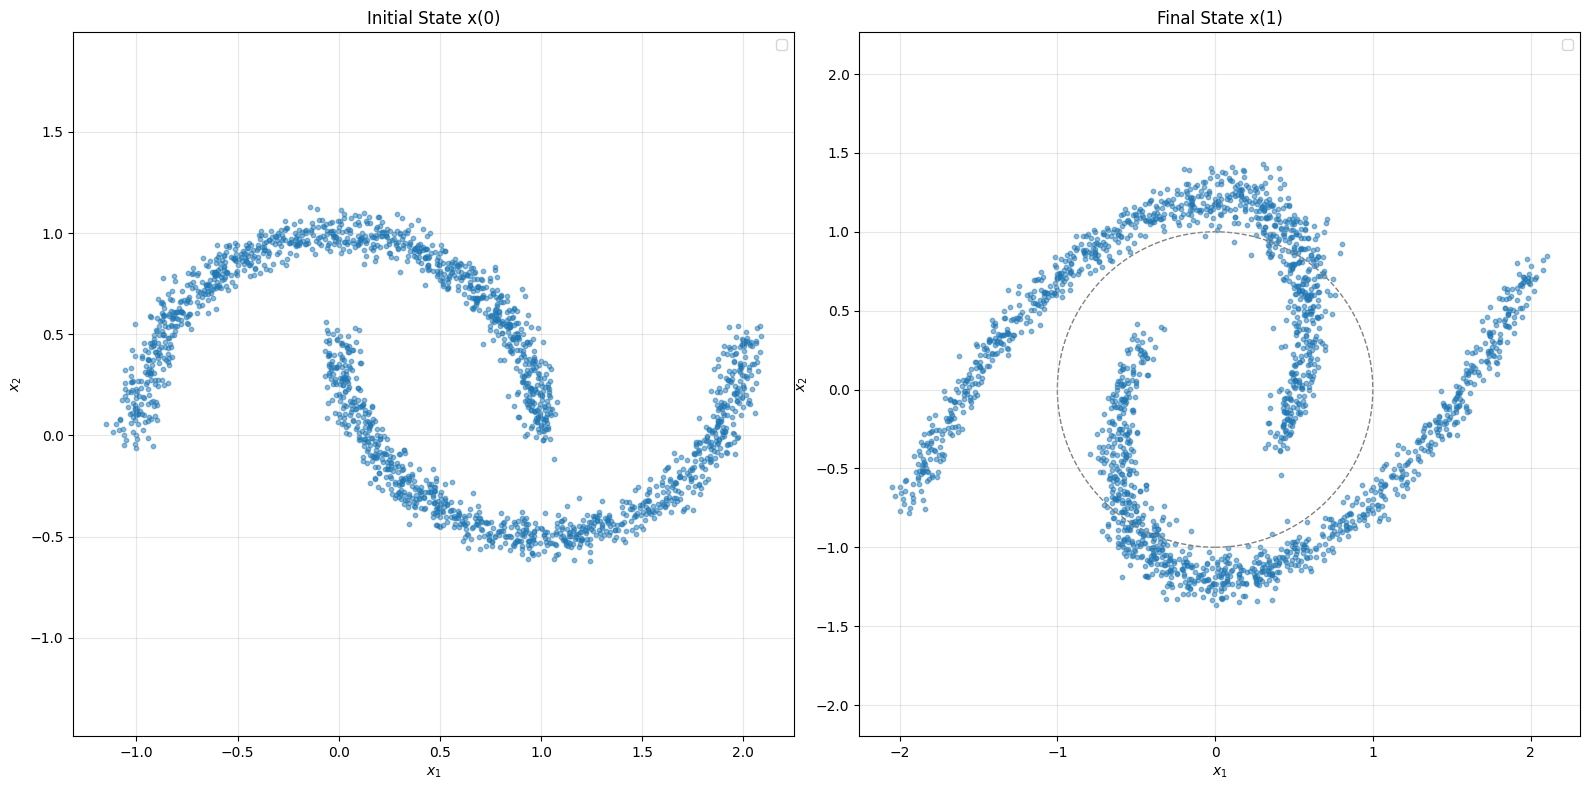

In [54]:
Synthetic2DViz.plot_trajectories(
    model,
    dataset,
    n_samples=2000,
    n_steps=100,
    save_path=os.path.join(
        FIGURES_DIR,
        f'01_{DATASET_NAME}_{MODEL_NAME}_trajectories.png'
    )
)
plt.tight_layout()
plt.show()


## 4. Visualizar Vector Field


In [ ]:
# Plotar vector field em diferentes tempos
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, t in enumerate([0.0, 0.5, 1.0]):
    Synthetic2DViz.plot_vector_field(
        model,
        xlim=(-5, 5),
        ylim=(-5, 5),
        n_grid=30,
        t=t,
        ax=axes[i],
        save_path=os.path.join(
            FIGURES_DIR,
            f'01_{DATASET_NAME}_{MODEL_NAME}_vector_fields.png'
        )
    )
plt.tight_layout()
plt.show()


## 5. Visualizar Transformação


Figure saved to: ../results/figures/01_moons_neuralode_transformation.png


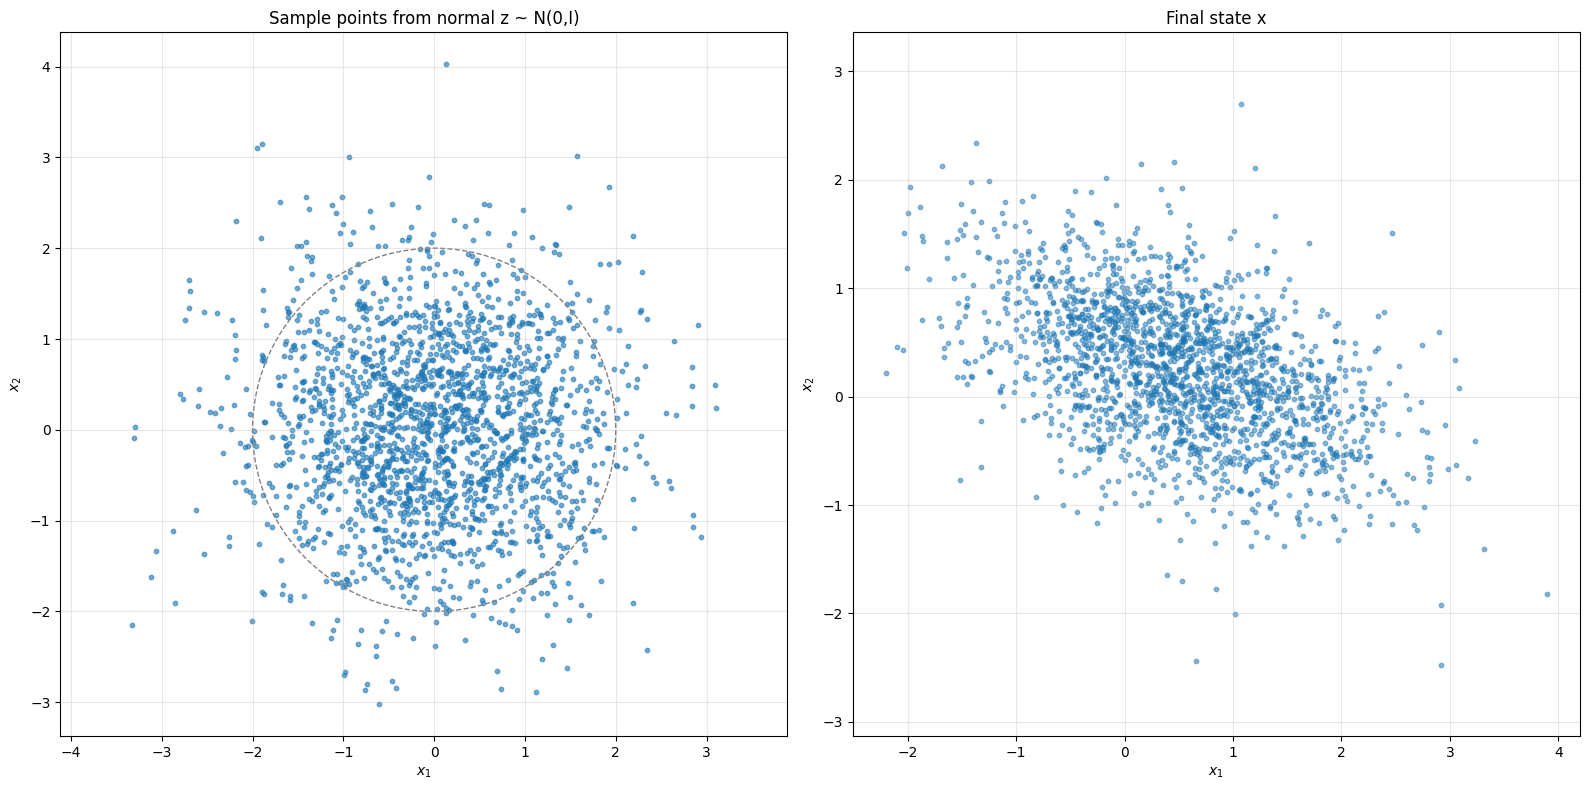

In [58]:
Synthetic2DViz.plot_transformation(
    model,
    n_samples=2000,
    n_steps=100,
    save_path=os.path.join(
        FIGURES_DIR,
        f'01_{DATASET_NAME}_{MODEL_NAME}_transformation.png'
    )
)
plt.tight_layout()
plt.show()


## 6. Analisar NFEs (Number of Function Evaluations)


In [ ]:
# Comparar diferentes solvers
solvers = ['euler', 'rk4', 'dopri5']
nfe_results = {}

# Usar amostras de N(0, I) para contagem de NFEs
sample_batch = torch.randn(10, 2).to(device)

print("=== Comparação de Solvers ===")
for solver in solvers:
    vf_test = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
    model_test = NeuralODE(
        vf_test,
        solver=solver,
        rtol=1e-3,
        atol=1e-4,
    ).to(device)
    model_test.vf.load_state_dict(model.vf.state_dict())
    nfe = count_nfe(model_test, sample_batch)
    nfe_results[solver] = nfe
    print(f"{solver}: {nfe} NFEs")

# Comparar diferentes tolerâncias
tolerances = [(1e-2, 1e-3), (1e-3, 1e-4), (1e-4, 1e-5)]
nfe_tol_results = {}

print("\n=== Comparação de Tolerâncias (dopri5) ===")
for rtol, atol in tolerances:
    vf_test = VectorField(features=2, hidden_dims=[64, 64], time_embed_dim=16)
    model_test = NeuralODE(
        vf_test,
        solver='dopri5',
        rtol=rtol,
        atol=atol,
    ).to(device)
    model_test.vf.load_state_dict(model.vf.state_dict())
    nfe = count_nfe(model_test, sample_batch)
    nfe_tol_results[(rtol, atol)] = nfe
    print(f"rtol={rtol}, atol={atol}: {nfe} NFEs")
